In [13]:
#用pagerank挖掘希拉里邮件中的人物关系
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [20]:
#数据加载
emails = pd.read_csv('/Applications/py_workspace/data_mining/data/PageRank/Emails.csv')
df_emails = pd.DataFrame(emails)
print(df_emails.loc[1])

#读取别名文件
file_aliases = pd.read_csv('/Applications/py_workspace/data_mining/data/PageRank/Aliases.csv')
df = pd.DataFrame(file_aliases)
print(df.loc[1])
aliases = {}
for index, row in file_aliases.iterrows():
  aliases[row['Alias']] = row['PersonId']

#读取人名文件
file_persons = pd.read_csv('/Applications/py_workspace/data_mining/data/PageRank/Persons.csv')
df_persons = pd.DataFrame(file_persons)
print(df_persons.loc[1])
persions = {}
for index, row in file_persons.iterrows():
    persions[row['Id']] = row['Name']

#针对别名进行转换
def unify_name(name):
    #姓名统一小写
    name = str(name).lower()
    #去掉“,”和“@”后面的内容
    name = name.replace(",","").split("@")[0]
    #别名转换
    if name in aliases.keys():
        return persions[aliases[name]]
    return name

Id                                                                              2
DocNumber                                                               C05739546
MetadataSubject                 H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...
MetadataTo                                                                      H
MetadataFrom                                                                  NaN
SenderPersonId                                                                NaN
MetadataDateSent                                        2011-03-03T05:00:00+00:00
MetadataDateReleased                                    2015-05-22T04:00:00+00:00
MetadataPdfLink                 DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...
MetadataCaseNumber                                                   F-2015-04841
MetadataDocumentClass                                               HRC_Email_296
ExtractedSubject                                                              NaN
ExtractedTo     

In [21]:
#将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

#设置边的权重等于发邮件的次数
edges_weigths_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weigths_temp:
        edges_weigths_temp[temp] = 1
    else:
        edges_weigths_temp[temp] = edges_weigths_temp[temp] + 1


In [22]:
#格式转化（from， to） ，weight ---》from，to， weight
edges_weigths = [(key[0], key[1],val) for key ,val in edges_weigths_temp.items()]

In [23]:
#画网格图
def show_graph(graph):
    #使用spring layout布局，类似中心放射状
    positions = nx.spring_layout(graph)
    #设置网格图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*2w
    nodesize = [x['pagerank'] * 20000 for v, x in graph.nodes(data = True)]
    #设置网格图中的边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data = True)]
    #绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size = nodesize, alpha = 0.4)
    #绘制边
    nx.draw_networkx_edges(graph, positions, edge_size = edgesize, alpha = 0.2)
    #绘制节点的label
    nx.draw_networkx_labels(graph, positions, font_size=10)

    plt.show()

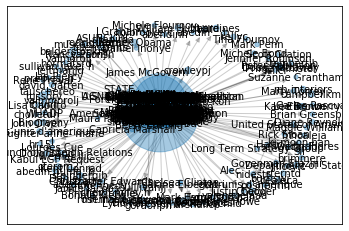

In [25]:
#创建一个有向图
graph = nx.DiGraph()
#设置有向图的路径和权重，（from， to， weight）
graph.add_weighted_edges_from(edges_weigths)
#记录每个节点（入）的pr值，并作为节点的pagerank属性
pagerank = nx.pagerank(graph)
#获取每个节点的pagerank数值
pagerank_list = {node: rank for node , rank in pagerank.items()}
#将pagerank数值作为节点的属性
nx.set_node_attributes(graph, name='pagerank', values=pagerank_list)
show_graph(graph)

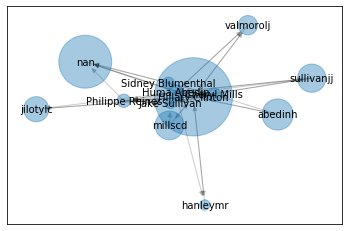

In [12]:
#将完整的图谱进行精简，设置pr的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
#复制一份计算好的网络图
small_graph = graph.copy()
#剪掉pr值小于pagerank_threshold的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)
show_graph(small_graph)

#将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
